### Importing Basic Libraries

In [2]:
#Used for data manipulations
import numpy as np
import pandas as pd
import math

#Used for data visualizations
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Importing warnings module to prevent them from being displayed
import warnings
warnings.filterwarnings('ignore')


# Used for Final analysis of the model
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

### Loading the Data

In [3]:
# lets read the dataset
data = pd.read_csv(".\\input\\Crop_recommendation.csv")

# lets check the shape of the dataset
print("Shape of the Dataset :", data.shape)

data.info()

Shape of the Dataset : (2200, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


### Converting the columns into Int

In [5]:
# Changing fields to numeric equivalents.(Useful while sorting the distances for finding nearest Neighbors)

data['N'] = pd.to_numeric(data['N'], errors='coerce')
data['P'] = pd.to_numeric(data['P'], errors='coerce')
data['K'] = pd.to_numeric(data['K'], errors='coerce')
data['temperature'] = data['temperature'].astype(int)
data['humidity'] = data['humidity'].astype(int)
data['ph'] = data['ph'].astype(int)
data['rainfall'] = data['rainfall'].astype(int)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   N            2200 non-null   int64 
 1   P            2200 non-null   int64 
 2   K            2200 non-null   int64 
 3   temperature  2200 non-null   int32 
 4   humidity     2200 non-null   int32 
 5   ph           2200 non-null   int32 
 6   rainfall     2200 non-null   int32 
 7   label        2200 non-null   object
dtypes: int32(4), int64(3), object(1)
memory usage: 103.2+ KB


## KNN Algorithm

K-Nearest Neighbors (KNN) is a simple yet powerful algorithm used in supervised learning for classification tasks

1. **Overview**:
   - KNN is a non-parametric algorithm, meaning it does not make any assumptions about the underlying data distribution.
   - It is called a "lazy learner" because it doesn't learn a discriminative function from the training data but rather memorizes the training instances.
   - KNN operates based on the assumption that similar instances are likely to have similar outputs.

2. **How it works**:
   - Given a new, unseen instance, KNN identifies the K nearest neighbors to that instance in the training data based on a distance metric (typically Euclidean distance).
   - For classification tasks, the algorithm assigns the majority class among the K nearest neighbors to the new instance.
   
   <img src="./Assets/KNN_flow.png" width="500" />

3. **Parameters**:
   - K: The number of neighbors to consider. Choosing an appropriate K value is crucial; a small K can be sensitive to noise, while a large K can lead to over-smoothing.
   - Distance metric: Typically Euclidean distance is used, but other distance metrics like Manhattan distance or cosine similarity can also be used based on the nature of the data.

6. **Implementation**:
   - Implementation involves loading the data, preprocessing (scaling, handling missing values, etc.), splitting it into training and testing sets, training the model, and evaluating its performance.

7. **Evaluation**:
   - Performance metrics for classification tasks include accuracy, precision, recall, F1-score, and ROC curves.

8. **Tuning**:
   - Hyperparameter tuning is essential, particularly for choosing the optimal K value and the appropriate distance metric.
   - Techniques like cross-validation can be used for hyperparameter tuning.

We utilize the standard Euclidean Norm, also known as the L2 Norm, as the default distance metric in our implementation.

The K mentioned here is given as a parameter and is not learnt, though there are thumb rules (such as sqrt(n), n = # datapoints) and some procedures which can make better choices for K.  

It's important to note that our implementation is non-parallelized, resulting in relatively slow performance. Depending on the dataset size, it may take between 5 to 15 minutes to produce results. However, the accuracy achieved by our implementation is comparable to that of standard library packages.

In [6]:
# Euclidean distance calculation.
def euclidean_distance(row: pd.Series, test_row: pd.Series) -> float:
    """
    Calculates the Euclidean distance between two data points.

    Args:
        row (pd.Series): A row from the training data.
        test_row (pd.Series): A row from the test data.

    Returns:
        float: The Euclidean distance between the two data points.
    """
    distance = 0
    for index, value in row.items():
        if index != 'label':
            distance += (value - test_row[index]) ** 2
    return math.sqrt(distance)

# Manhattan distance calculation
def manhattan_distance(row: pd.Series, test_row: pd.Series) -> float:
    """
    Calculates the Manhattan distance between two data points.

    Args:
        row (pd.Series): A row from the training data.
        test_row (pd.Series): A row from the test data.

    Returns:
        float: The Manhattan distance between the two data points.
    """
    distance = 0
    for index, value in row.items():
        if index != 'label':
            distance += abs(value - test_row[index])
    return distance

# Return the label with maximum count only.
def get_majority_label(neighbour_list: list) -> str:
    """
    Determines the majority label from a list of nearest neighbors.

    Args:
        neighbour_list (list): List of nearest neighbors with their labels.

    Returns:
        str: The majority label among the neighbors.
    """
    frequency_list = []
    for item in neighbour_list:
        for freq_item in frequency_list:
            if freq_item[0] == item[1]:
                freq_item[1] += 1
                break
        else:
            frequency_list.append([item[1], 1])
    majority_label = ''
    max_frequency = 0
    for item in frequency_list:
        if max_frequency < item[1]:
            majority_label = item[0]
            max_frequency = item[1]
    return majority_label

# For classification, calculate the distances between the new data point and all other test data points,then sort these distances and select the K nearest neighbors along with their labels.
# Next, determine the majority label among these neighbors and assign that label to the given data point.

def knn_classifier(train_data: pd.DataFrame, test_data: pd.DataFrame, k: int, metric: str) -> float:
    """
    Performs K-Nearest Neighbors classification.

    Args:
        train_data (pd.DataFrame): Training data.
        test_data (pd.DataFrame): Test data.
        k (int): Number of neighbors to consider.
        metric (str): Metric to use for distance calculation ('euclidean' or 'manhattan').

    Returns:
        float: Accuracy percentage of the KNN classification.
    """
    total_tests = test_data.shape[0]
    total_correct_classifications = 0
    for _, test_row in test_data.iterrows():
        nearest_neighbours = []
        for _, train_row in train_data.iterrows():
            if metric == 'euclidean': # for euclidean metric
                nearest_neighbours.append((euclidean_distance(train_row, test_row), train_row['label']))
            elif metric == 'manhattan': # for manhattan metric
                nearest_neighbours.append((manhattan_distance(train_row, test_row), train_row['label']))
            else:
                raise ValueError("Invalid metric. Please use 'euclidean' or 'manhattan'.")
        nearest_neighbours.sort()
        nearest_neighbours = nearest_neighbours[:k-1]
        if test_row['label'] == get_majority_label(nearest_neighbours):
            total_correct_classifications += 1
    return (total_correct_classifications / total_tests) * 100



### Data Splitting into train, validation and test

1. **Training Set**: 
   - Purpose: The training set is used to train the machine learning model. It contains labeled data points that the model uses to learn patterns and relationships between features and their corresponding labels.
   - Importance: Training on a sufficiently large and diverse training set helps the model generalize well to unseen data and learn robust patterns in the data.

2. **Validation Set**: 
   - Purpose: The validation set is used to evaluate the performance of the trained model during its development and tuning phase. It helps in comparing different models or variations of the same model and tuning hyperparameters.
   - Importance: By evaluating the model on a separate validation set, we can detect overfitting, select the best-performing model, and tune hyperparameters for optimal performance.

3. **Test Set**: 
   - Purpose: The test set is used to provide an unbiased evaluation of the final trained model's performance. It contains labeled data points that the model has not seen during training or validation.
   - Importance: Evaluating the model on a separate test set helps in assessing its generalization ability and estimating its performance on unseen data. It provides a realistic estimate of how well the model is likely to perform in real-world scenarios.

Splitting the data into these three sets helps in ensuring that the machine learning model is trained, validated, and tested properly, following best practices in model development and evaluation.

In [8]:
# Split data into 70-15-15 as train, validation, and test data sets
train_set = data.sample(frac=0.7, random_state=8)
remaining_data = data.drop(train_set.index)

validation_set = remaining_data.sample(frac=0.5, random_state=8)
test_set = remaining_data.drop(validation_set.index)

train_set = train_set.reset_index(drop=True)
validation_set = validation_set.reset_index(drop=True)
test_set = test_set.reset_index(drop=True)


# Parameter K: first choice
K = math.ceil(math.sqrt(train_set.shape[0]))


In [10]:
print("Train set shape:", train_set.shape)
print("Validation set shape:", validation_set.shape)
print("Test set shape:", test_set.shape)

Train set shape: (1540, 8)
Validation set shape: (330, 8)
Test set shape: (330, 8)


### Running the KNN on test data

In [14]:
#Knn function call

#initially we are using Euclidean metric only
print("Accuracy of KNN: ",knn_classifier(train_set,test_set,k=K,metric='euclidean'))


Accuracy of KNN:  93.93939393939394


### Hyper Parameter Tuning (on validation set)
##### Finding best k value
One of the challenges in a KNN algorithm is finding the best 'k' i.e. the number of neighbors to be used in the majority vote while deciding the class. Generally, it is advisable to test the accuracy of your model for different values of k and then select the best one from them.

### Using Euclidean Metric

In [20]:
euc_accuracies = []
ks = range(1, 20)
for k in ks:
    accuracy = knn_classifier(train_set,validation_set,k=k,metric='euclidean')
    euc_accuracies.append(accuracy)

print("Accuracies using Euclidean metric: ")
print(euc_accuracies)

Accuracies using Euclidean metric: 
[0.0, 97.87878787878788, 97.87878787878788, 97.87878787878788, 98.18181818181819, 97.27272727272728, 98.18181818181819, 97.27272727272728, 97.57575757575758, 96.66666666666667, 97.57575757575758, 96.96969696969697, 97.57575757575758, 96.96969696969697, 96.96969696969697, 96.66666666666667, 96.36363636363636, 95.75757575757575, 96.36363636363636]


#### Acuracies(Euclidean) vs K value plot

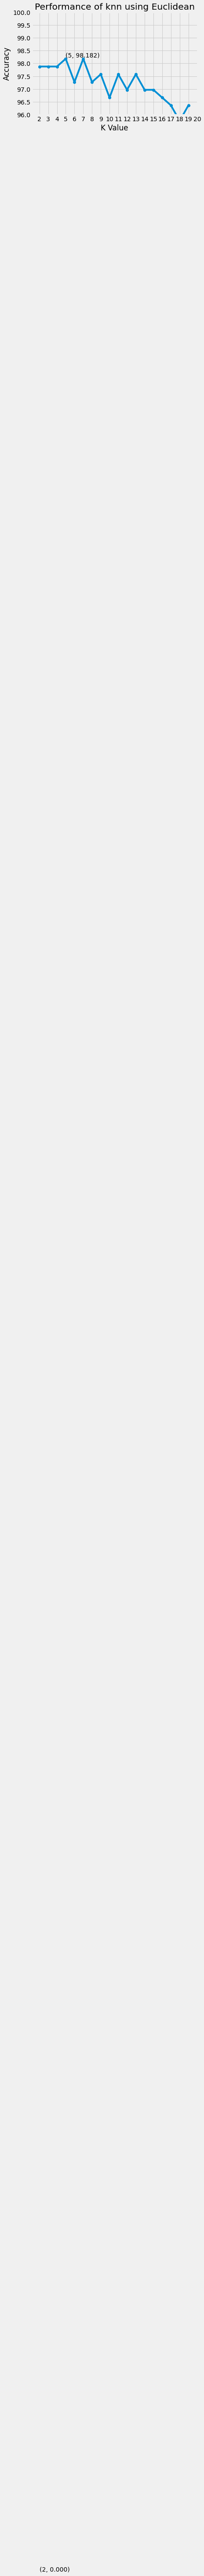

In [21]:
max_accuracy = max(euc_accuracies)
max_index = euc_accuracies.index(max_accuracy)
max_k = ks[max_index]
plt.plot(ks[1:], euc_accuracies[1:], marker='o', linestyle='-')  # Plot from index 1 onwards
plt.text(2, euc_accuracies[0], f'(2, {euc_accuracies[0]:.3f})', verticalalignment='bottom')  # Add text annotation
plt.scatter(max_k, max_accuracy, color='red')  # Mark the point with highest accuracy
plt.text(max_k, max_accuracy, f'({max_k}, {max_accuracy:.3f})', verticalalignment='bottom')  # Add text annotation
plt.title('Performance of knn using Euclidean')
plt.xlabel('K Value')
plt.ylabel('Accuracy')
plt.xticks(range(2, 21))
plt.ylim(96, 100)
plt.grid(True)

### Using Manhattan Metric

In [22]:
manh_accuracies = []
km = range(1, 20)
for k in km:
    accuracy = knn_classifier(train_set,validation_set,k=k,metric='manhattan')
    manh_accuracies.append(accuracy)

print("Accuracies using Manhattan metric: ")
print(manh_accuracies)

Accuracies using Manhattan metric: 
[0.0, 97.57575757575758, 97.57575757575758, 97.27272727272728, 96.96969696969697, 96.96969696969697, 97.57575757575758, 96.96969696969697, 97.57575757575758, 97.27272727272728, 97.27272727272728, 97.27272727272728, 97.57575757575758, 96.36363636363636, 96.36363636363636, 95.75757575757575, 96.06060606060606, 95.75757575757575, 96.06060606060606]


#### Acuracies(Manhattan) vs K value plot

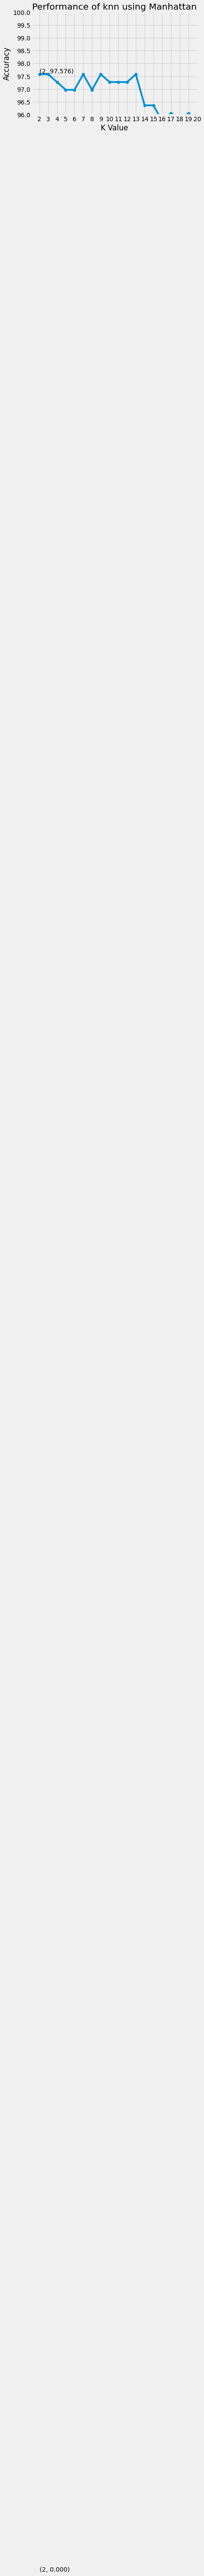

In [23]:
max_accuracy = max(manh_accuracies)
max_index = manh_accuracies.index(max_accuracy)
max_k = km[max_index]
plt.plot(km[1:], manh_accuracies[1:], marker='o', linestyle='-')  # Plot from index 1 onwards
plt.text(2, manh_accuracies[0], f'(2, {manh_accuracies[0]:.3f})', verticalalignment='bottom')  # Add text annotation
plt.scatter(max_k, max_accuracy, color='red')  # Mark the point with highest accuracy
plt.text(max_k, max_accuracy, f'({max_k}, {max_accuracy:.3f})', verticalalignment='bottom')  # Add text annotation
plt.title('Performance of knn using Manhattan')
plt.xlabel('K Value')
plt.ylabel('Accuracy')
plt.xticks(range(2, 21))
plt.ylim(96, 100)
plt.grid(True)

#### As we can clearly see better performance of the KNN using the Euclidean Metric, and also the best k - value is 5, Now lets run the KNN on test set using the best Parameters (metric = euclidean, k= 5)

### Running KNN using Best parameters:

In [24]:
print("Accuracy of KNN: ",knn_classifier(train_set,test_set,k=5,metric='euclidean'))

Accuracy of KNN:  98.48484848484848


### Conclusion

Accuracy before tuning:  93.93939393939394

Accuracy after tuning: 98.48484848484848